In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import os
import math
import itertools
import pickle
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

### Read in Data

In [4]:
sims = ['beta006_multiNPI_0vax_hicom', 'beta006_multiNPI_20vax_hicom', 'beta006_multiNPI_40vax_hicom']
partitions = np.arange(5)
sim_names = [sim + '_' + str(part) + '.csv' for sim in sims for part in partitions]
sim_names

['beta006_multiNPI_0vax_hicom_0.csv',
 'beta006_multiNPI_0vax_hicom_1.csv',
 'beta006_multiNPI_0vax_hicom_2.csv',
 'beta006_multiNPI_0vax_hicom_3.csv',
 'beta006_multiNPI_0vax_hicom_4.csv',
 'beta006_multiNPI_20vax_hicom_0.csv',
 'beta006_multiNPI_20vax_hicom_1.csv',
 'beta006_multiNPI_20vax_hicom_2.csv',
 'beta006_multiNPI_20vax_hicom_3.csv',
 'beta006_multiNPI_20vax_hicom_4.csv',
 'beta006_multiNPI_40vax_hicom_0.csv',
 'beta006_multiNPI_40vax_hicom_1.csv',
 'beta006_multiNPI_40vax_hicom_2.csv',
 'beta006_multiNPI_40vax_hicom_3.csv',
 'beta006_multiNPI_40vax_hicom_4.csv']

In [5]:
df = pd.DataFrame()
for file in sim_names:
    tmpdf = pd.read_csv(file, header = 0, dtype = {'rep': int, 'p_vax': float, 'test_freq': int})
    part = int(file[-5])
    tmpdf['partition'] = np.repeat(part, repeats = tmpdf.shape[0])
    df = df.append(tmpdf, ignore_index = True)

In [6]:
# Renumber reps to remove duplicates
df['rep'] = df['rep'] + df['partition']*20
df.tail()

,rep,test_freq,p_sd,p_fm,p_vax,cum_uniq_inf,ext_inf_ct,partition
181495,96,28,1.0,1.0,0.4,85,89,4
181496,97,28,1.0,1.0,0.4,82,82,4
181497,98,28,1.0,1.0,0.4,112,111,4
181498,99,28,1.0,1.0,0.4,91,92,4
181499,100,28,1.0,1.0,0.4,97,95,4


### Fit OLS Model

In [7]:
# If no testing is included, it has to be treated as categorical since 0 is worst followed by 28, but 3 is best
testdf = df.loc[df.test_freq!=0]

In [8]:
X = testdf[['test_freq', 'p_sd', 'p_fm', 'p_vax']]
X.tail()

,test_freq,p_sd,p_fm,p_vax
181495,28,1.0,1.0,0.4
181496,28,1.0,1.0,0.4
181497,28,1.0,1.0,0.4
181498,28,1.0,1.0,0.4
181499,28,1.0,1.0,0.4


In [9]:
y = testdf['cum_uniq_inf']

In [10]:
X_train_Sm = sm.add_constant(X)
ls = sm.OLS(y,X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:           cum_uniq_inf   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                 7.369e+04
Date:                Wed, 26 May 2021   Prob (F-statistic):               0.00
Time:                        09:01:31   Log-Likelihood:            -6.7770e+05
No. Observations:              145200   AIC:                         1.355e+06
Df Residuals:                  145195   BIC:                         1.355e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        213.8188      0.207   1033.838      0.0

* For every 10% increase in social distancing, cumulative incidence declines by 45.6743/10 = 4.56743
* For every 10% increase in mask wearing, cumulative incidence declines on average by 57.5501/10 = 5.75501
* For every 10% increase in immunity, cumulative incidence declines on average by 170.7266/10 = 17.07266
* After controlling for these other factors, for every one day increase in testing frequency, cumulative incidence increases by 0.5646 on average. Conversely, for every one day decrease in testing frequency, cumulative incidence decreases by 0.5646 on average.

In [12]:
4.46743/0.5646

7.912557562876374

In [13]:
5.75501/0.5646

10.193074743181015

In [14]:
17.07266/0.5646

30.238505136379736

* A 10% increase in social distancing is equivalent to testing 7.9 days more frequently.
* A 10% increase in masking is equivalent to testing 10.2 days more frequently.
* A 10% increase in immunity is equivalent to testing 30.0 days more frequently.

In [19]:
(4.46743/(7*0.5646))*0.1

0.11303653661251963

In [20]:
(5.75501/(7*0.5646))*0.1

0.1456153534740145

In [21]:
(17.07266/(7*0.5646))*0.1

0.43197864480542486

Moving from testing once every 14 days to once every 7 days is equivalent to:
* 11.4% increase in social distancing
* 14.3% increase in mask wearing
* 42.7% increase in immunity

In [22]:
redux = 10
tcoeff = 0.5646
sdcoeff = 4.46743
fmcoeff = 5.75501
vxcoeff = 17.07266

In [23]:
print(redux/tcoeff)
print((redux/sdcoeff)*0.1)

17.711654268508678
0.22384234336072417


In [24]:
print((redux/fmcoeff)*0.1)
print((redux/vxcoeff)*0.1)

0.1737616442021821
0.05857318074629262


To reduce cumulative incidence by 10 people (1.5% of student population), you need to:
* increase testing frequency by 17.7 days
* increase social distancing by 22.4%
* increase masking by 17.4%
* increase immunity by 5.9%

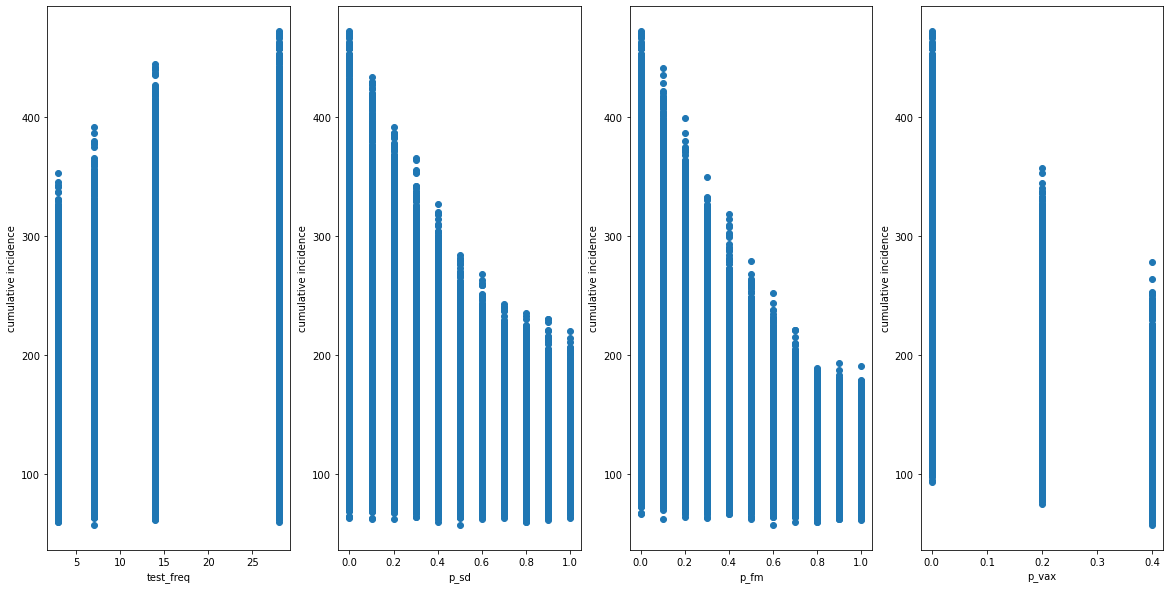

In [25]:
f, axs = plt.subplots(1, 4, figsize = (20, 10))
for (i,col) in enumerate(X):
    axs[i].scatter(testdf[col], testdf['cum_uniq_inf'])
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('cumulative incidence')